<a href="https://colab.research.google.com/github/vitamin1312/MLc/blob/main/tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
!pip install graphviz

In [ ]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install treeinterpreter
!pip install waterfallcharts

  Preparing metadata (setup.py) ... done
  Created wheel for waterfallcharts: filename=waterfallcharts-3.8-py3-none-any.whl size=3390 sha256=9b2f50016a0117c8582310cc71e44b10fa71d8641f658ef402aea23edf405d63
  Stored in directory: /root/.cache/pip/wheels/bd/34/6c/58fce34a3b8ec5607aff650db14ceb41db8223ac217423371b
Successfully built waterfallcharts


In [ ]:
creds = '{"username":"username","key":"key"}'
SEED = 42

In [ ]:
from pathlib import Path
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [ ]:
from fastai.tabular.all import *
from kaggle import api
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import AgglomerativeClustering
from graphviz import Source
import dtreeviz
from sklearn import tree
import seaborn as sns
from scipy.cluster import hierarchy as hc
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [ ]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

In [ ]:
def rmse_(pred, y): return np.round(np.sqrt((pred-y)**2).mean(), 6)
def m_rmse_(m, xs, y): return rmse_(m.predict(xs), y)

In [ ]:
comp = 'bluebook-for-bulldozers'
path = URLs.path(comp)
path

Path('/root/.fastai/archive/bluebook-for-bulldozers')

In [ ]:
Path.BASE_PATH = path

In [ ]:
if not path.exists():
    path.mkdir(parents=true)
    api.competition_download_cli(comp, path=path)
    shutil.unpack_archive(str(path/f'{comp}.zip'), str(path))

path.ls(file_type='text')

100%|██████████| 48.4M/48.4M [00:03<00:00, 16.6MB/s]


(#7) [Path('Test.csv'),Path('Machine_Appendix.csv'),Path('Valid.csv'),Path('ValidSolution.csv'),Path('median_benchmark.csv'),Path('TrainAndValid.csv'),Path('random_forest_benchmark_test.csv')]

In [ ]:
df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')

In [ ]:
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,10000.0,1919201,21435,149,2.0,2005,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412694,6333345,10500.0,1882122,21436,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412695,6333347,12500.0,1944213,21435,149,2.0,2005,NaN,NaN,1/28/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
412696,6333348,10000.0,1794518,21435,149,2.0,2006,NaN,NaN,3/7/2012 0:00,...,None or Unspecified,None or Unspecified,None or Unspecified,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large',
       'Compact'], dtype=object)

In [ ]:
sizes = ('Large','Large / Medium','Medium','Small','Mini','Compact')

df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(reversed(sizes), ordered=True, inplace=True)

In [ ]:
df['ProductSize']

0            NaN
1         Medium
2            NaN
3          Small
4            NaN
           ...  
412693      Mini
412694      Mini
412695      Mini
412696      Mini
412697      Mini
Name: ProductSize, Length: 412698, dtype: category
Categories (6, object): ['Compact' < 'Mini' < 'Small' < 'Medium' < 'Large / Medium' < 'Large']

In [ ]:
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

In [ ]:
df = add_datepart(df, 'saledate')
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df_test = add_datepart(df_test, 'saledate')

In [ ]:
' '.join(o for o in df.columns if o.startswith('sale'))

'saleYear saleMonth saleWeek saleDay saleDayofweek saleDayofyear saleIs_month_end saleIs_month_start saleIs_quarter_end saleIs_quarter_start saleIs_year_end saleIs_year_start saleElapsed'

In [ ]:
df

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDay,saleDayofweek,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,Low,521D,...,16,3,320,False,False,False,False,False,False,1.163635e+09
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,Low,950FII,...,26,4,86,False,False,False,False,False,False,1.080259e+09
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,High,226,...,26,3,57,False,False,False,False,False,False,1.077754e+09
3,1139251,10.558414,1026470,332,121,3.0,2001,3486.0,High,PC120-6E,...,19,3,139,False,False,False,False,False,False,1.305763e+09
4,1139253,9.305651,1057373,17311,121,3.0,2007,722.0,Medium,S175,...,23,3,204,False,False,False,False,False,False,1.248307e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412693,6333344,9.210340,1919201,21435,149,2.0,2005,NaN,NaN,30NX,...,7,2,67,False,False,False,False,False,False,1.331078e+09
412694,6333345,9.259131,1882122,21436,149,2.0,2005,NaN,NaN,30NX2,...,28,5,28,False,False,False,False,False,False,1.327709e+09
412695,6333347,9.433484,1944213,21435,149,2.0,2005,NaN,NaN,30NX,...,28,5,28,False,False,False,False,False,False,1.327709e+09
412696,6333348,9.210340,1794518,21435,149,2.0,2006,NaN,NaN,30NX,...,7,2,67,False,False,False,False,False,False,1.331078e+09


In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]
splits = (list(train_idx), list(valid_idx))

In [ ]:
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [ ]:
len(to.train), len(to.valid)

(404710, 7988)

In [ ]:
to.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,1.077754e+09,1,1


In [ ]:
to.classes['ProductSize']

['#na#', 'Compact', 'Mini', 'Small', 'Medium', 'Large / Medium', 'Large']

In [ ]:
save_pickle(path/'to.pkl',to)

In [ ]:
to = load_pickle(path/'to.pkl')

In [ ]:
to.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,saleDayofyear,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,121,3.0,2004,68.0,2,963,...,320,1,1,1,1,1,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,121,3.0,1996,4640.0,2,1745,...,86,1,1,1,1,1,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,121,3.0,2001,2838.0,1,336,...,57,1,1,1,1,1,1,1.077754e+09,1,1


In [ ]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4, random_state=SEED)
m.fit(xs, y)

DecisionTreeRegressor(max_leaf_nodes=4, random_state=42)

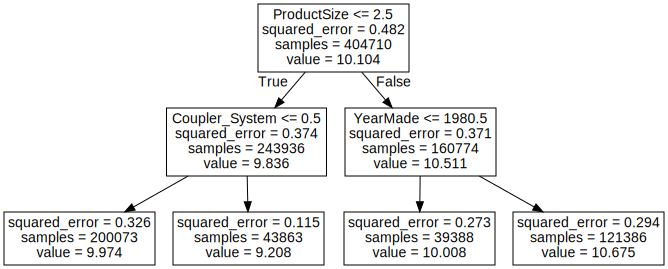

In [ ]:
Source(tree.export_graphviz(m, out_file=None, feature_names=xs.columns))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


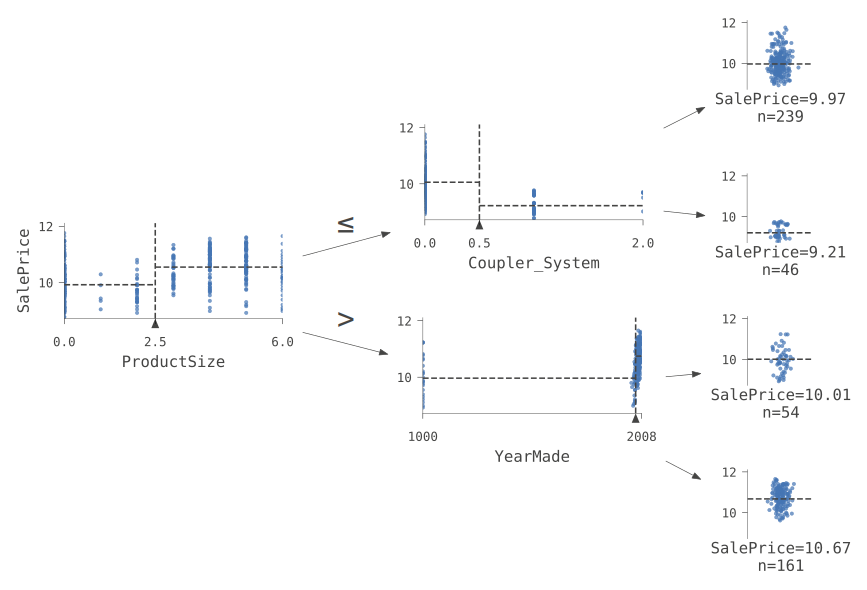

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]

viz_cmodel = dtreeviz.model(m,
                           tree_index=3,
                           X_train=xs.values[samp_idx],
                           y_train=y.values[samp_idx],
                           feature_names=xs.columns,
                           target_name=dep_var)

viz_cmodel.view(scale=2.1,
                fontname='monospace',
                label_fontsize=10,
                orientation='LR')

In [ ]:
xs.loc[xs['YearMade']<1900, 'YearMade'] = 1950
valid_xs.loc[valid_xs['YearMade']<1900, 'YearMade'] = 1950

In [ ]:
m = DecisionTreeRegressor(max_leaf_nodes=4, random_state=SEED).fit(xs, y)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names


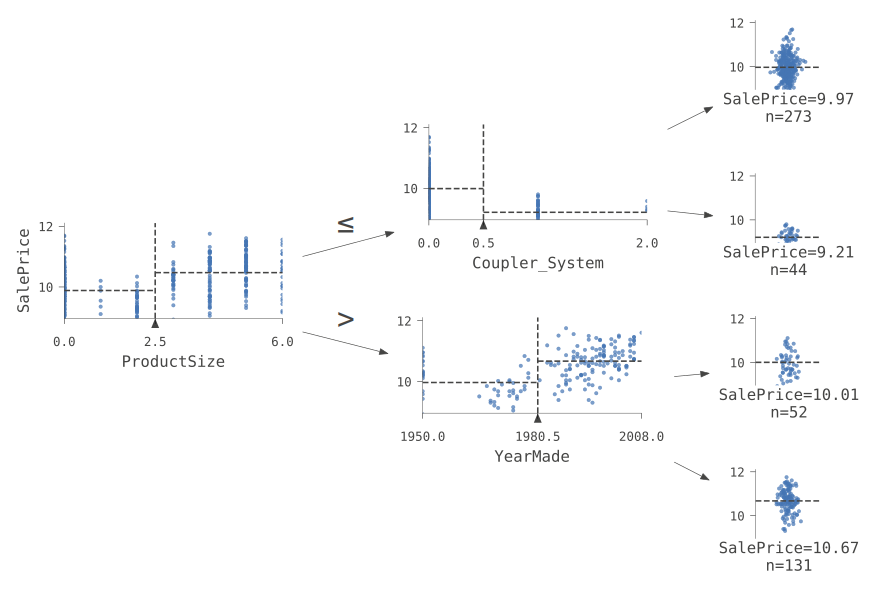

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]

viz_cmodel = dtreeviz.model(m,
                           tree_index=3,
                           X_train=xs.values[samp_idx],
                           y_train=y.values[samp_idx],
                           feature_names=xs.columns,
                           target_name=dep_var)

viz_cmodel.view(scale=2.1,
                fontname='monospace',
                label_fontsize=10,
                orientation='LR')

In [ ]:
m = DecisionTreeRegressor(random_state=SEED).fit(xs, y)

In [ ]:
m_rmse_(m, xs, y)

0.0

In [ ]:
m_rmse_(m, valid_xs, valid_y)

0.249295

In [ ]:
m.get_n_leaves(), len(xs)

(324857, 404710)

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25, random_state=SEED)
m.fit(to.train.xs, to.train.y)
m_rmse_(m, xs, y), m_rmse_(m, valid_xs, valid_y)

(0.166462, 0.215376)

In [ ]:
m.get_n_leaves()

12413

In [ ]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
                                 max_samples=max_samples, max_features=max_features,
                                 min_samples_leaf=min_samples_leaf, oob_score=True,
                                 random_state=SEED).fit(xs, y)

In [ ]:
m = rf(xs, y)
m_rmse_(m, xs, y), m_rmse_(m, valid_xs, valid_y)

(0.122522, 0.174787)

In [ ]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])

In [ ]:
rmse_(preds.mean(axis=0), valid_y)

0.174787

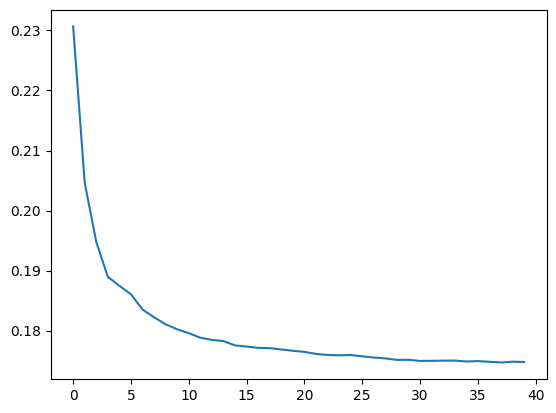

In [ ]:
plt.plot([rmse_(preds[:i+1].mean(axis=0), valid_y) for i in range(40)]);

In [ ]:
rmse_(m.oob_prediction_, y)

0.152308

In [ ]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])
preds.shape

(40, 7988)

In [ ]:
preds_std = preds.std(0)

In [ ]:
preds_std[:5]

array([0.28600646, 0.12086085, 0.11237233, 0.22705268, 0.12849904])

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns,
                         'imp': m.feature_importances_}).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi

,cols,imp
6,ProductSize,0.189859
57,YearMade,0.185711
30,Coupler_System,0.073903
3,fiSecondaryDesc,0.061100
65,saleElapsed,0.049222
...,...,...
45,saleIs_month_start,0.000018
46,saleIs_quarter_end,0.000010
47,saleIs_quarter_start,0.000007
48,saleIs_year_end,0.000000


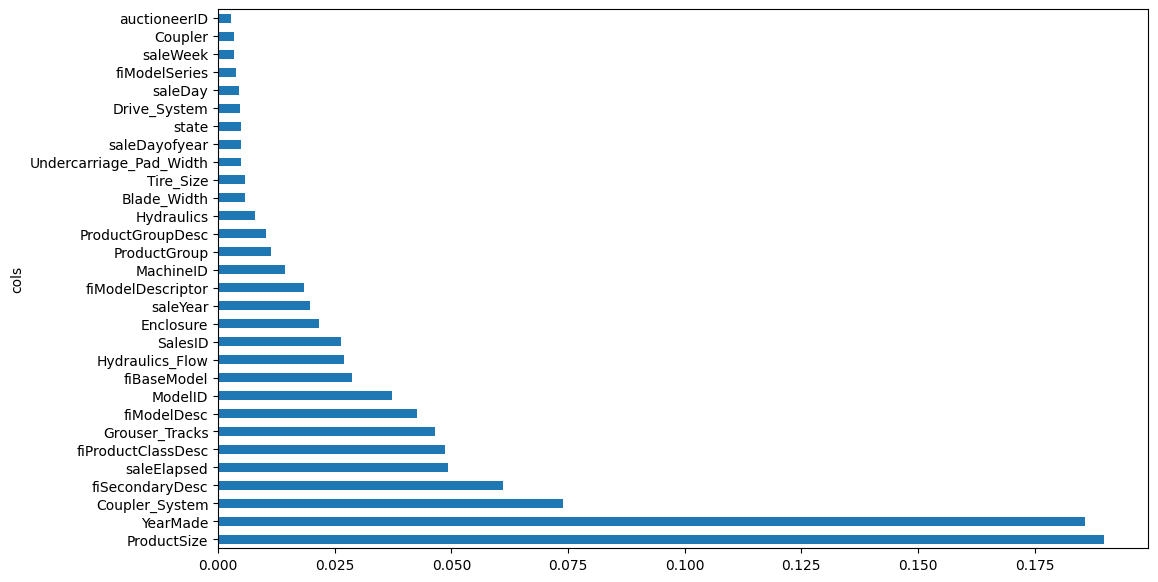

In [ ]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12, 7), legend=False)
plot_fi(fi[:30]);

In [ ]:
to_keep = fi[fi.imp > 0.005].cols
len(to_keep)

22

In [ ]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]
m = rf(xs_imp, y)

In [ ]:
m_rmse_(m, xs_imp, y), m_rmse_(m, valid_xs_imp, valid_y)

(0.132109, 0.172312)

<Axes: ylabel='cols'>

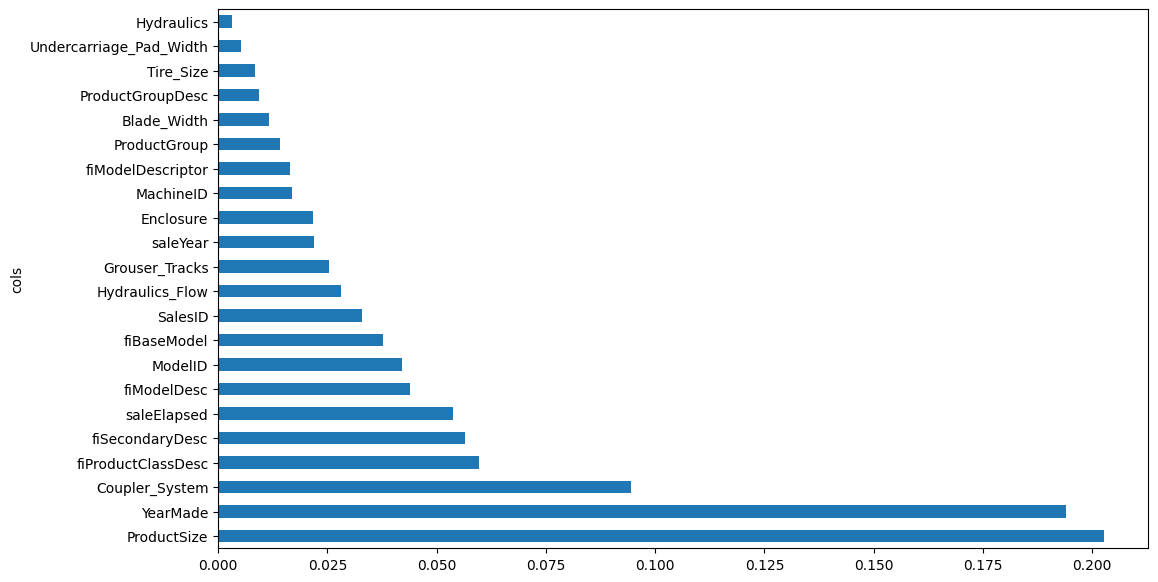

In [ ]:
plot_fi(rf_feat_importance(m, xs_imp))

<Axes: >

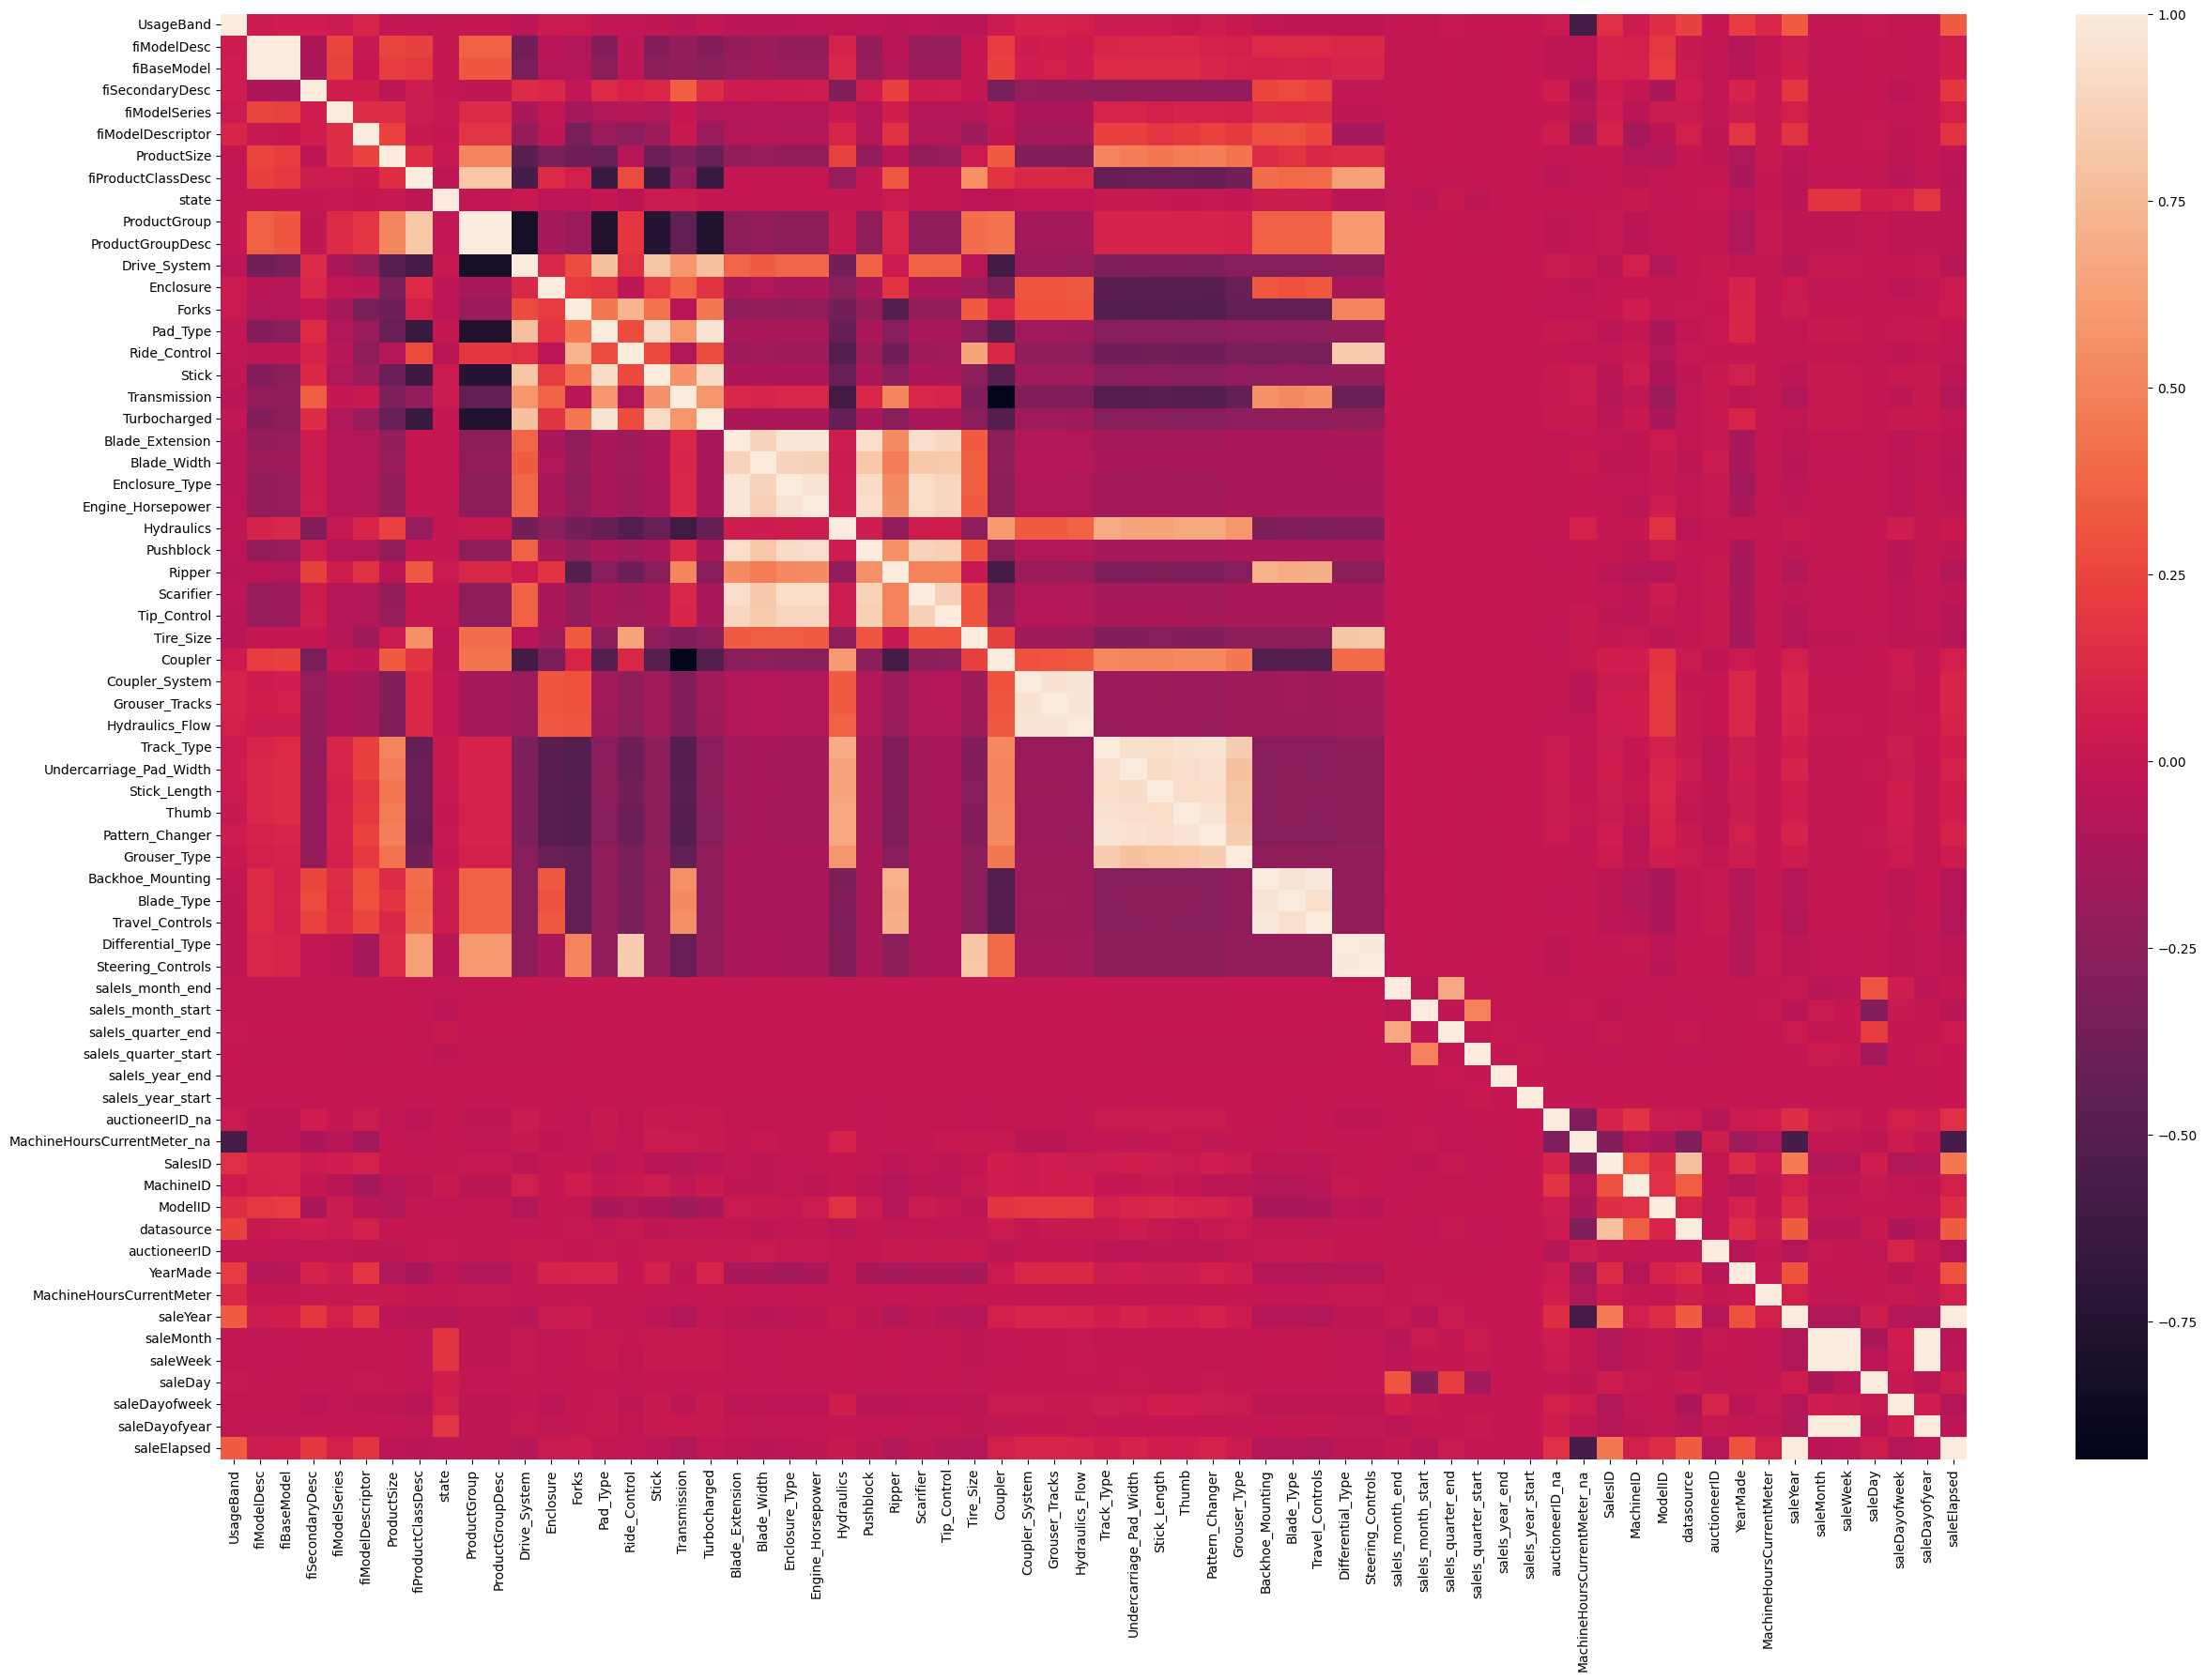

In [ ]:
plt.figure(figsize=(30, 20))
sns.heatmap(xs.corr())

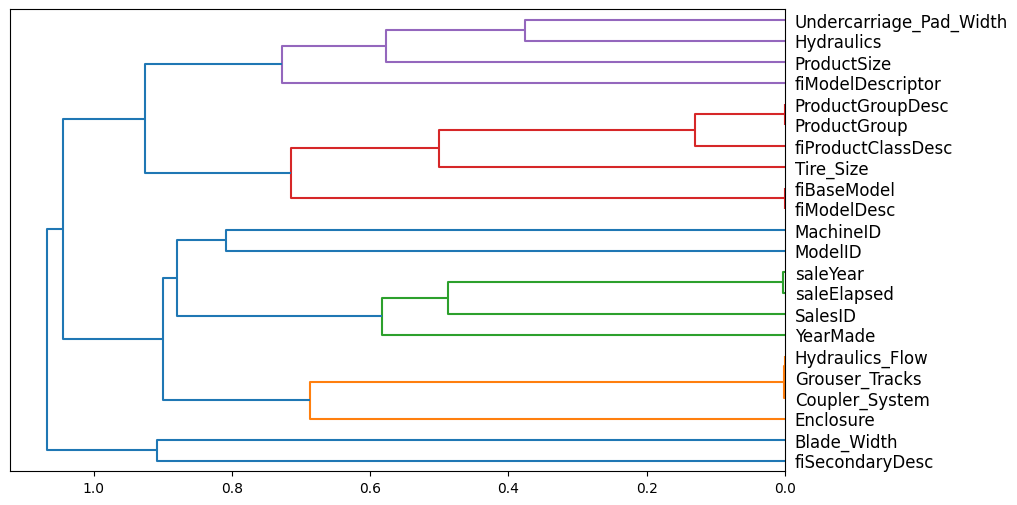

In [ ]:
cluster_columns(xs_imp)

In [ ]:
def get_oob(df):
    m = RandomForestRegressor(
                                n_estimators=40,
                                min_samples_leaf=15,
                                max_samples=50000,
                                max_features=0.5,
                                n_jobs=-1,
                                oob_score=True,
                                random_state=SEED
                            )
    m.fit(df, y)
    return m.oob_score_

In [ ]:
get_oob(xs_imp)

0.87703887067806

In [ ]:
xs.columns

Index(['UsageBand', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls',
       'saleIs_month_end', 'saleIs_month_start', 'saleIs_quarter_end',
       'saleIs_quarter_start', 'saleIs_year_end', 'saleIs_year_start',
       'auctioneerID_na', 'MachineHoursCurrentMeter_na', 'SalesID',
       'Mac

In [ ]:
{c:get_oob(xs_imp.drop(c, axis=1)) for c in (
    'saleYear', 'saleElapsed',
    'ProductGroup','fiProductClassDesc',
    'fiModelDesc', 'fiBaseModel',
    'Hydraulics_Flow','Grouser_Tracks',
    'Coupler_System')}

{'saleYear': 0.8758179356742359,
 'saleElapsed': 0.8710121193341568,
 'ProductGroup': 0.8765780987961214,
 'fiProductClassDesc': 0.8727498765740136,
 'fiModelDesc': 0.8753202502344841,
 'fiBaseModel': 0.8753002362750044,
 'Hydraulics_Flow': 0.8764142836653748,
 'Grouser_Tracks': 0.8768205244150977,
 'Coupler_System': 0.8762234847297177}

In [ ]:
to_drop = ['saleYear', 'ProductGroup', 'fiBaseModel', 'Grouser_Tracks']
get_oob(xs_imp.drop(to_drop, axis=1))

0.8745788715095042

In [ ]:
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)
save_pickle(path/'xs_final.pkl', xs_final)
save_pickle(path/'valid_xs_final.pkl', valid_xs_final)

In [ ]:
xs_final = load_pickle(path/'xs_final.pkl')
valid_xs_final = load_pickle(path/'valid_xs_final.pkl')

In [ ]:
m = rf(xs_final, y)
m_rmse_(m, xs_final, y), m_rmse_(m, valid_xs_final, valid_y)

(0.133357, 0.173752)

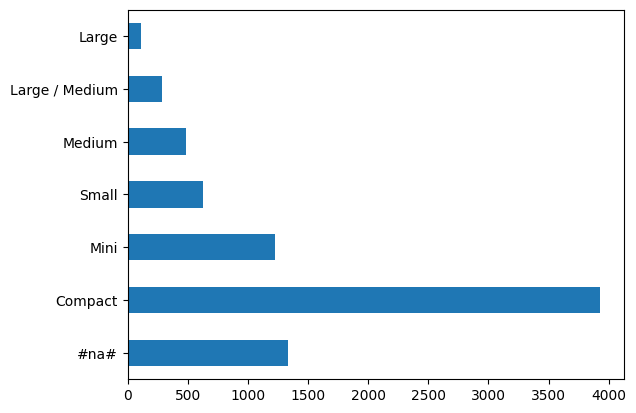

In [ ]:
p = valid_xs_final['ProductSize'].value_counts(sort=False).plot.barh()
c = to.classes['ProductSize']
plt.yticks(range(len(c)), c);

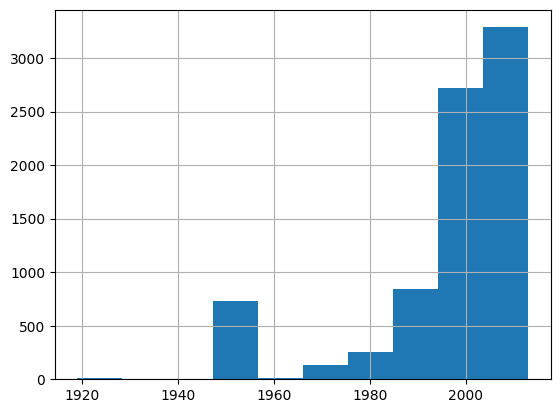

In [ ]:
ax = valid_xs_final['YearMade'].hist()

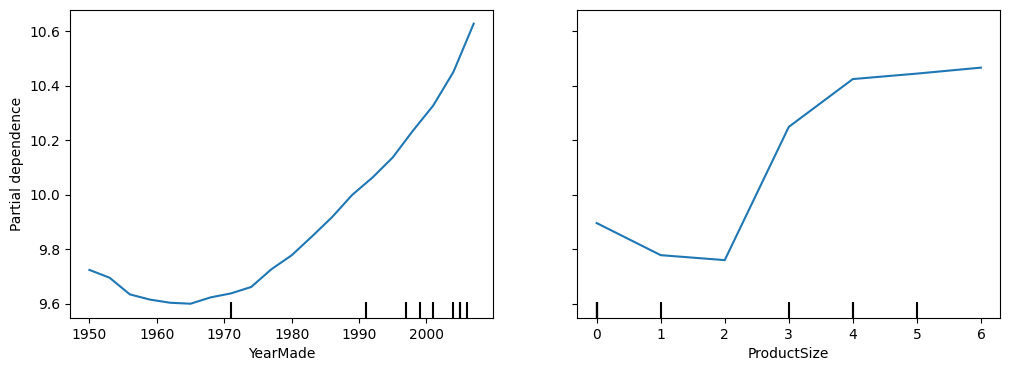

In [ ]:
fig,ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(m, valid_xs_final, ['YearMade', 'ProductSize'],
                                        grid_resolution=20, ax=ax)

In [ ]:
row = valid_xs_final.iloc[:5]

In [ ]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

In [ ]:
prediction[0], bias[0], contributions[0].sum()

(array([10.02932254]), 10.104284736365315, -0.07496219886818294)

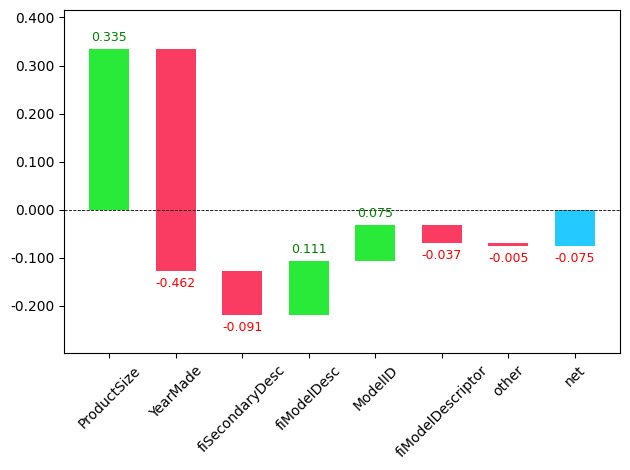

In [ ]:
waterfall(valid_xs_final.columns, contributions[0], threshold=0.08,
          rotation_value=45, formatting='{:,.3f}');

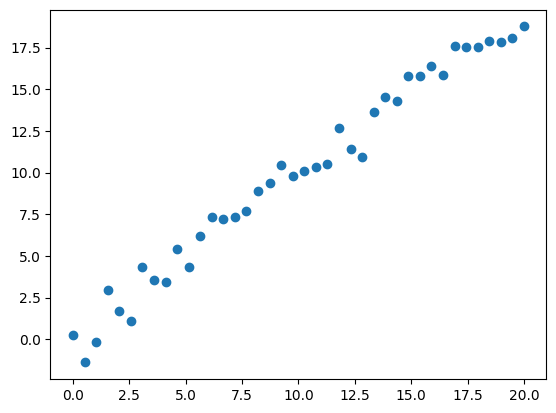

In [ ]:
x_lin = torch.linspace(0, 20, steps=40)
y_lin = x_lin + torch.randn_like(x_lin)
plt.scatter(x_lin, y_lin);

In [ ]:
xs_lin = x_lin.unsqueeze(1)
x_lin.shape, xs_lin.shape

(torch.Size([40]), torch.Size([40, 1]))

In [ ]:
x_lin[:, None].shape

torch.Size([40, 1])

In [ ]:
m_lin = RandomForestRegressor().fit(xs_lin[:30], y_lin[:30])

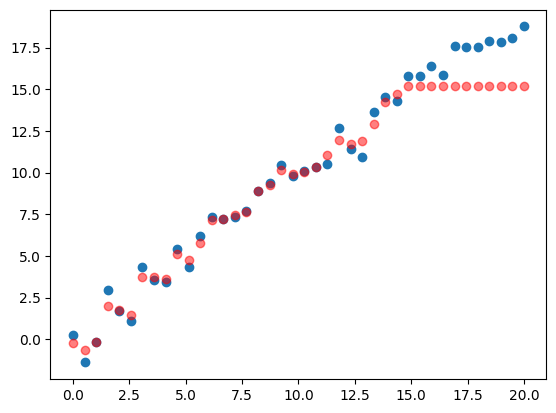

In [ ]:
plt.scatter(x_lin, y_lin)
plt.scatter(x_lin, m_lin.predict(xs_lin), color='red', alpha=0.5);

In [ ]:
df_dom = pd.concat([xs_final, valid_xs_final])
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_xs_final))

m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:6]

,cols,imp
4,saleElapsed,0.890220
9,SalesID,0.074204
12,MachineID,0.030848
1,YearMade,0.001006
7,ModelID,0.000957
6,fiModelDesc,0.000530


In [ ]:
m = rf(xs_final, y)
print('orig', m_rmse_(m, valid_xs_final, valid_y))

for c in ('SalesID', 'saleElapsed', 'MachineID'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse_(m, valid_xs_final.drop(c, axis=1), valid_y))

orig 0.173752
SalesID 0.173384
saleElapsed 0.1767
MachineID 0.172738


In [ ]:
time_vars = ['SalesID', 'MachineID']
xs_final_time = xs_final.drop(time_vars, axis=1)
valid_xs_time = valid_xs_final.drop(time_vars, axis=1)

m = rf(xs_final_time, y)
m_rmse_(m, valid_xs_time, valid_y)

0.171255

<Axes: >

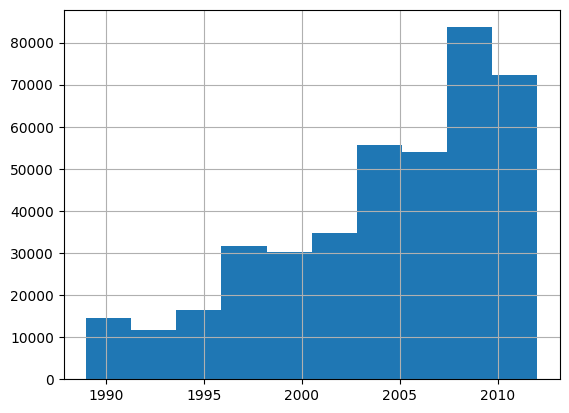

In [ ]:
xs['saleYear'].hist()

In [ ]:
filt = xs['saleYear']>2004
xs_filt = xs_final_time[filt]
y_filt = y[filt]

In [ ]:
m = rf(xs_filt, y_filt)
m_rmse_(m, xs_filt, y_filt), m_rmse_(m, valid_xs_time, valid_y)

(0.128429, 0.171211)

In [ ]:
df_nn = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_nn['ProductSize'] = df_nn['ProductSize'].astype('category')
df_nn['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)
df_nn[dep_var] = np.log(df_nn[dep_var])
df_nn = add_datepart(df_nn, 'saledate')

In [ ]:
df_nn_final = df_nn[list(xs_final_time.columns) + [dep_var]]

In [ ]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [ ]:
df_nn_final[cat_nn].nunique()

ProductSize                   6
YearMade                     73
Coupler_System                2
fiSecondaryDesc             177
fiProductClassDesc           74
fiModelDesc                5059
ModelID                    5281
Hydraulics_Flow               3
Enclosure                     6
fiModelDescriptor           140
ProductGroupDesc              6
Hydraulics                   12
Blade_Width                   6
Tire_Size                    17
Undercarriage_Pad_Width      19
dtype: int64

In [ ]:
df_nn_final[cont_nn]

,saleElapsed
0,1.163635e+09
1,1.080259e+09
2,1.077754e+09
3,1.305763e+09
4,1.248307e+09
...,...
412693,1.331078e+09
412694,1.327709e+09
412695,1.327709e+09
412696,1.331078e+09


In [ ]:
xs_filt2 = xs_filt.drop('fiModelDescriptor', axis=1)
valid_xs_time2 = valid_xs_time.drop('fiModelDescriptor', axis=1)
m2 = rf(xs_filt2, y_filt)
m_rmse_(m2, xs_filt2, y_filt), m_rmse_(m2, valid_xs_time2, valid_y)

(0.12988, 0.171644)

In [ ]:
cat_nn.remove('fiModelDesc')

In [ ]:
df_nn_final[cat_nn].nunique()

ProductSize                   6
YearMade                     73
Coupler_System                2
fiSecondaryDesc             177
fiProductClassDesc           74
ModelID                    5281
Hydraulics_Flow               3
Enclosure                     6
ProductGroupDesc              6
Hydraulics                   12
Blade_Width                   6
Tire_Size                    17
Undercarriage_Pad_Width      19
dtype: int64

In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [ ]:
dls = to_nn.dataloaders(1024)

In [ ]:
y = to_nn.train.y
y.min(),y.max()

(8.465899, 11.863583)

In [ ]:
learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=0.00019054606673307717)

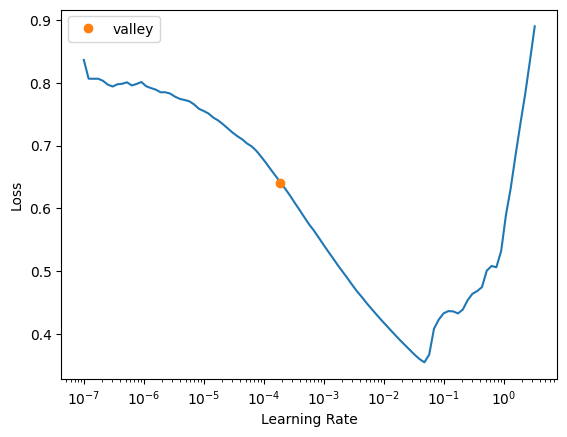

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.064349,0.066507,00:06
1,0.054679,0.058821,00:07
2,0.049781,0.063866,00:05
3,0.044186,0.053321,00:09
4,0.040972,0.051480,00:07


In [ ]:
preds,targs = learn.get_preds()
rmse_(preds,targs)

tensor(0.1704)

In [ ]:
rf_preds = m.predict(valid_xs_time)
ens_preds = (to_np(preds.squeeze()) + rf_preds) /2

torch.Tensor

In [ ]:
rmse_(ens_preds, valid_y)

0.167015